# Cosmology with enlib and orphics



In this short tutorial, we will:

1. Define a map geometry
2. Generate a random galaxy catalog
3. Make a map from the catalog
4. Calculate and bin the autospectrum of the galaxy map
5. Call CAMB from Python to get a lensing power spectrum
6. Create a simulated lensing map using the power spectrum
7. Calcate and bin the cross-spectrum of the lensing map and galaxy map

In [43]:
from __future__ import print_function

# The main mapwork module
from enlib import enmap

import numpy as np
import matplotlib.pyplot as plt

# Tools for working with enmaps, i/o, catalogs and statistics
from orphics import maps as omaps,io,catalogs as cats,stats,cosmology as cosmo


In [26]:
# Let's define a geometry centered on the equator by default

shape,wcs = omaps.rect_geometry(width_deg=20.,px_res_arcmin=0.5)

# shape gives us the shape of the numpy matrix storing the map

print(shape)

# wcs is the World Coordinate System info that tells enlib what pixels correspond to what locations on the sky.
# Enlib essentially extends the numpy array to include wcs information

print(wcs)

(2400, 2400)
car:{cdelt:[0.008333,0.008333],crval:[0,0],crpix:[1200,1200]}


In [28]:
# What are the bounds of this geometry in degrees?
bounds = enmap.box(shape,wcs)*180./np.pi
print(bounds)

[[-10. -10.]
 [10. 10.]]


In [29]:
# Let's generate a random catalog of "galaxies"
Ngals = 10000000
ras = np.random.uniform(bounds[0,1],bounds[1,1],Ngals)  # ras between the minimum and maximum ra of our geometry
decs = np.random.uniform(bounds[0,0],bounds[1,0],Ngals) # same for decs

In [30]:
# Now let's make a map out of these
# This requires you to specify the geometry through shape,wcs and give a list of the ras and decs
cmapper = cats.CatMapper(shape,wcs,ras,decs)

# Once you initialize this object, it makes a "counts" map. We can get an overdensity map from it.
delta = cmapper.counts/cmapper.counts.mean()-1.


Calculating pixels...
Done with pixels...
Calculating histogram...


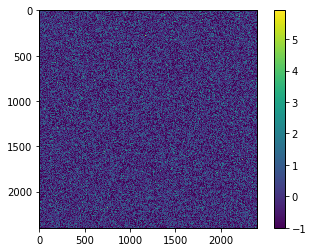

In [31]:
# Let's plot it
plt.imshow(delta)
plt.colorbar()
plt.show()

In [32]:
# The sum of the counts map should be the number of galaxies 
print (cmapper.counts.sum())
# And the sum of the overdensity should be pretty close to zero
print (delta.sum())

10000000.0
-2.64538613237e-10


In [44]:
# Now let's do some fourier space operations
# We initialize a fourier calculator for this geometry
fc = omaps.FourierCalc(shape,wcs)
# And calculate the autospectrum of the overdensity. The last two return arguments 
# are the fourier transforms of the galaxy map
p2d,kgal,_ = fc.power2d(delta)
# This returns a 2D power spectrum. We need to bin it in annuli to get a 1D spectrum.
# Let's define the bin edges (these are multipole Ls)
bin_edges = np.arange(100,2000,100)
# Let's initialize a binner object
# This requires the magnitudes of the L wavenumbers in each fourier space pixel of the map.
# This is typically called modlmap (for modulus of L map).
# We can get it from cmapper.counts since that is an enmap.
modlmap = cmapper.counts.modlmap()

# With the modlmap and the bin edges, we can define the binner
binner = stats.bin2D(modlmap,bin_edges)

# and apply it to the 2d power spectrum
cents, p1d = binner.bin(p2d)

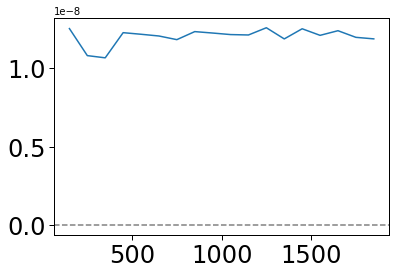

In [35]:
# Let's plot it

pl = io.Plotter()
pl.add(cents,p1d)
pl.hline()
pl.done()



It looks like white noise since we randomly put down galaxies (no clustering).

In [36]:
# Let's initialize a CAMB cosmology. This could take a few seconds.

cc = cosmo.Cosmology(lmax=2000)

Generating theory Cls...


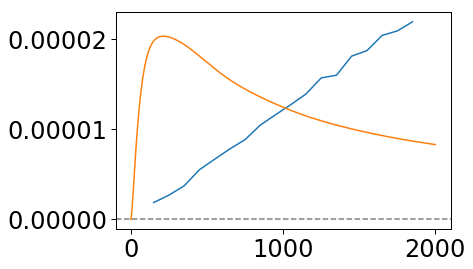

In [38]:
# Now let's get the Clkk power spectrum from the initialized cosmology and plot it 
# along with the galaxy autospectrum
ells = np.arange(0,2000,1)
clkk = cc.theory.gCl("kk",ells)

pl = io.Plotter()
pl.add(cents,p1d*cents)
pl.add(ells,clkk*ells)
pl.hline()
pl.done()





Note that I'm plotting $LC_L$ here.

In [42]:
# Now let's generate gaussian random fields with Clkk power.
# We need to reshape the power spectrum into a polarization-friendly form.
# It is a 3D matrix, the first two indices are the polarization indices.
# The required shape is (1,1,N_L) where the only (0,0,:) element is 
# saying we don't want polarization since it is just a TT spectrum.
ps = np.reshape(clkk,(1,1,clkk.size))
mg = omaps.MapGen(shape,wcs,ps)





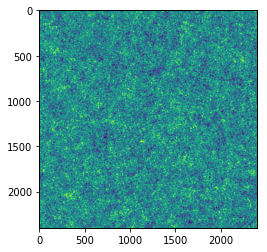

In [40]:
# Now let's generate a map and plot it
kappa_sim = mg.get_map()

plt.imshow(kappa_sim)
plt.show()


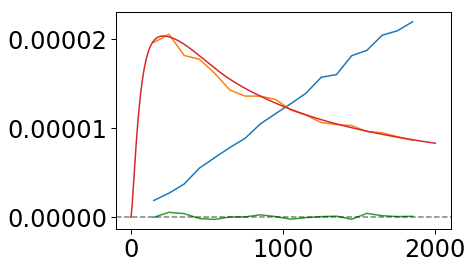

In [46]:
# Let's calculate the auto-spectrum of the kappa map
p2d_kappa,kkappa,_ = fc.power2d(kappa_sim)
cents, p1d_kappa = binner.bin(p2d_kappa)

# Now let's calculate its cross-power with the galaxy map we made earlier. What do you expect it to be?
# Notice that we are using fc.f2power instead of fc.power2d. FFTs are expensive, so if we already have
# the fourier transforms of our maps from previous operations, we can reuse them to calculate a cross power
# spectrum. Instead of redoing the FFTs, this operation is instant, since it just multiplies the 
# fourier transforms calculate earlier and applies the appropriate scaling factor.
p2d_cross = fc.f2power(kgal,kkappa)
cents, p1d_cross = binner.bin(p2d_cross)
pl = io.Plotter()
pl.add(cents,p1d*cents)
pl.add(cents,p1d_kappa*cents)
pl.add(cents,p1d_cross*cents)
pl.add(ells,cltt*ells)
pl.hline()
pl.done()

It is zero (green) as expected since we didn't make any effort to ensure that the phases of our generated kappa map have any correlation with the completely unrelated galaxy map we made earlier!